1. install the dependencies, and import huggingface core libraries. setting the training device on Colab.

In [1]:
!pip install -q transformers accelerate peft datasets bitsandbytes
!pip install -q matplotlib scikit-learn

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.6 MB/s eta 0:00:00
Using device: cuda


2. loading the ROCOv2 dataset

Build a multimodal data preprocessing pipeline. This pipeline employs streaming loading technology to efficiently read large-scale medical image datasets (ROCO v2) and utilizes a custom collate function to transform raw image-text pairs into model-compatible tensor formats, providing standardized batch data for subsequent training.

In [29]:
MODEL_ID = "openai/clip-vit-base-patch32"
MAX_SAMPLES = 2000
BATCH_SIZE = 32

print("Loading CLIP Processor...")
processor = CLIPProcessor.from_pretrained(MODEL_ID)

print(f"Streaming loading ROCO v2 dataset(taking the first {MAX_SAMPLES} rows)...")

dataset = load_dataset("eltorio/ROCOv2-radiology", split="train", streaming=True, trust_remote_code=True)
dataset = dataset.take(MAX_SAMPLES)


# In ROCO v2, the image field is typically named ‘image’, and the text field is named ‘caption’
# To prevent issues with some sample images being grayscale (L mode), they are uniformly converted to RGB
def collate_fn(batch):
    images = [item['image'].convert("RGB") for item in batch]
    texts = [item['caption'] for item in batch]

    inputs = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77
    )
    return inputs

# build the  DataLoader
train_loader = DataLoader(list(dataset), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
print(f"data loading finished, The number of Batch: {len(train_loader)}")

Loading CLIP Processor...


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'eltorio/ROCOv2-radiology' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'eltorio/ROCOv2-radiology' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Streaming loading ROCO v2 dataset(taking the first 2000 rows)...


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2eeb8a69-ba51-4751-a969-cc68973f6420)')' thrown while requesting GET https://huggingface.co/datasets/eltorio/ROCOv2-radiology/resolve/80ffeef4eb8d34d27cb5c2815305f1d8aee8a83c/data/train-00000-of-00027.parquet
Retrying in 1s [Retry 1/5].


data loading finished, The number of Batch: 63


3. Model buiding and LoRA setup

The pre-trained CLIP base model utilizes the library to inject a low-rank adapter into the Transformer's attention layers.

This freezes 99% of the original parameters, activating only a minimal set of incremental parameters for training, thereby achieving efficient domain transfer.

For fine-tuning the Q and V modules, we implement LoRA on these two components. In the code, we traverse the original CLIP model to locate all q and v layers.


A LoRA branch is then parallel-connected alongside them. This automatically freezes all original model weights, keeping them unchanged during training while only updating the newly added LoRA branch.

In [32]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || "
        f"trainable%: {100 * trainable_params / all_param:.2f}%"
    )

# loading pretrained CLIP
original_model = CLIPModel.from_pretrained(MODEL_ID)

# setup the LoRA
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
)

model = get_peft_model(original_model, config)
model = model.to(device)

print("LoRA building finished：")
print_trainable_parameters(model)

LoRA 模型构建完成：
trainable params: 983040 || all params: 152260353 || trainable%: 0.65%


4. training stage


The contrastive loss is automatically computed through a series of complex mathematical operations within Hugging Face's CLIP model.

开始训练...


Epoch 1/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 Average Loss: 2.1113


Epoch 2/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2 Average Loss: 1.7433


Epoch 3/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3 Average Loss: 1.5062


Epoch 4/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4 Average Loss: 1.3009


Epoch 5/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5 Average Loss: 1.1058


Epoch 6/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.9267


Epoch 7/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.7676


Epoch 8/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.6198


Epoch 9/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.5096


Epoch 10/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.3930


Epoch 11/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11 Average Loss: 0.3407


Epoch 12/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12 Average Loss: 0.2795


Epoch 13/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13 Average Loss: 0.2348


Epoch 14/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14 Average Loss: 0.2086


Epoch 15/15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15 Average Loss: 0.1795


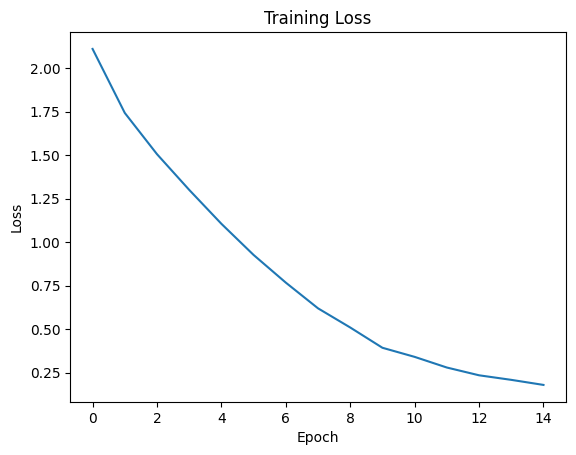

LoRA 权重已保存至 'medical_clip_lora' 文件夹


In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
EPOCHS = 15

model.train()
loss_history = []

print("training...")
for epoch in range(EPOCHS):
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in progress_bar:
        inputs = {k: v.to(device) for k, v in batch.items()}


        # Forward Propagation
        # The CLIPModel internally calculates image_embeds and text_embeds automatically
        outputs = model(**inputs, return_loss=True)


        loss = outputs.loss

        # back propogatioon
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# save the LoRA weights
model.save_pretrained("medical_clip_lora")

5. 0 shot multi label classification



🌊 检测到流式数据集 (Streaming)，正在抽取接下来的 3 张...
📋 备选标签总数: 20 个

--- 测试样本 1/3 ---


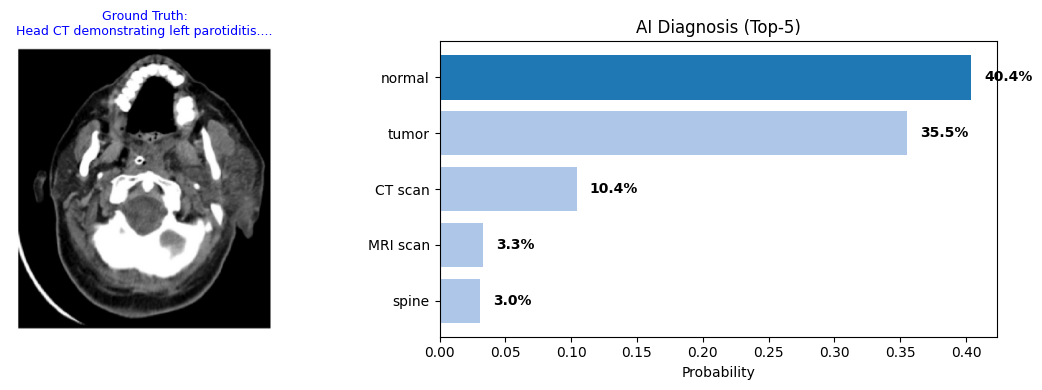

--- 测试样本 2/3 ---


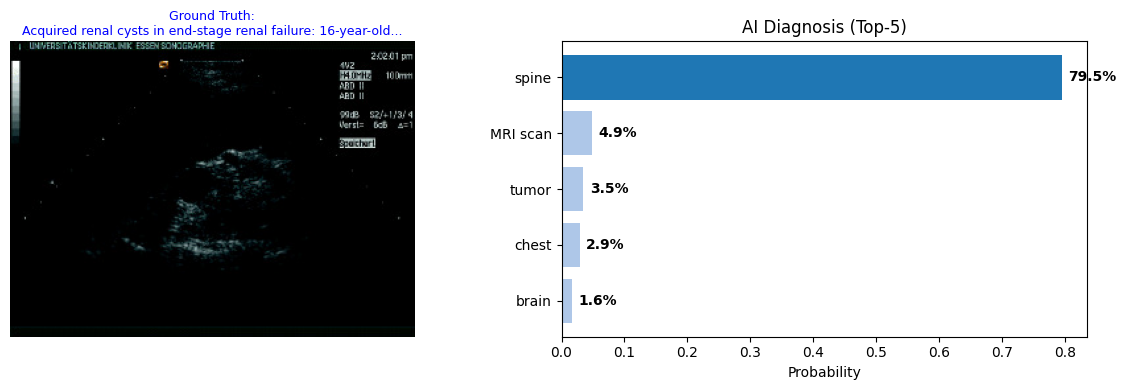

--- 测试样本 3/3 ---


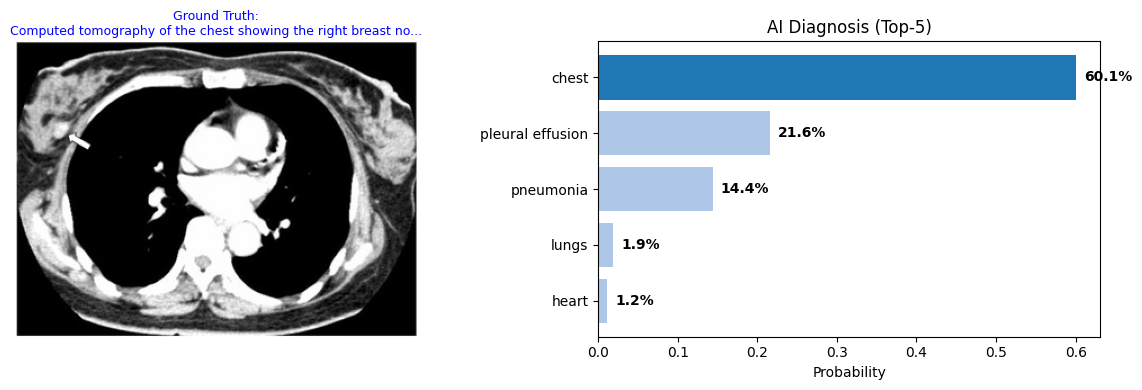

In [26]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch

# our labels to be tested
candidate_labels = [
    "brain", "spine", "chest", "lungs", "heart",
    "abdomen", "knee", "hand", "pelvis",
    "X-ray", "CT scan", "MRI scan", "ultrasound",
    "pneumonia", "fracture", "pleural effusion",
    "tumor", "edema", "normal", "hemorrhage"
]

def test_random_hard_samples(dataset, model, processor, num_samples=3):
    samples_to_test = []


    try:

        total_images = len(dataset)
        print(f" (Total: {total_images})，extracting randomly...")
        random_indices = random.sample(range(total_images), num_samples)
        samples_to_test = [dataset[i] for i in random_indices]

    except TypeError:
        print(f"extracting the next {num_samples} samples")
        iterator = iter(dataset)
        for _ in range(num_samples):
            try:
                samples_to_test.append(next(iterator))
            except StopIteration:
                break

    print(f"candidate labels: {len(candidate_labels)} 个\n")



    # 3. itertate all the images
    for i, sample in enumerate(samples_to_test):
        print(f"--- test sample {i+1}/{len(samples_to_test)} ---")


        image = sample['image'].convert("RGB")


        true_label_str = "Unknown"
        if 'label' in sample:
            try:
                true_label_str = dataset.features['label'].int2str(sample['label'])
            except:
                true_label_str = str(sample['label'])
        elif 'caption' in sample:
            true_label_str = sample['caption'][:60] + "..."


        text_inputs = [f"A medical image of {label}" for label in candidate_labels]

        inputs = processor(
            text=text_inputs,
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]


        top_k = 5
        top_indices = probs.argsort()[-top_k:][::-1]
        top_scores = probs[top_indices]
        top_labels = [candidate_labels[j] for j in top_indices]

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis("off")

        plt.title(f"Ground Truth:\n{true_label_str}", fontsize=9, color="blue", wrap=True)

        plt.subplot(1, 2, 2)
        y_pos = np.arange(len(top_labels))
        colors = ['#1f77b4' if s == max(top_scores) else '#aec7e8' for s in top_scores]

        bars = plt.barh(y_pos, top_scores, align='center', color=colors)
        plt.yticks(y_pos, top_labels)
        plt.xlabel('Probability')
        plt.title(f'AI Diagnosis (Top-{top_k})')
        plt.gca().invert_yaxis()

        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                     f'{width:.1%}', ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

test_random_hard_samples(dataset, model, processor, num_samples=3)

🌊 检测到流式数据集 (Streaming)，正在抽取接下来的 20 张...
📋 备选标签总数: 20 个

--- 测试样本 1/20 ---


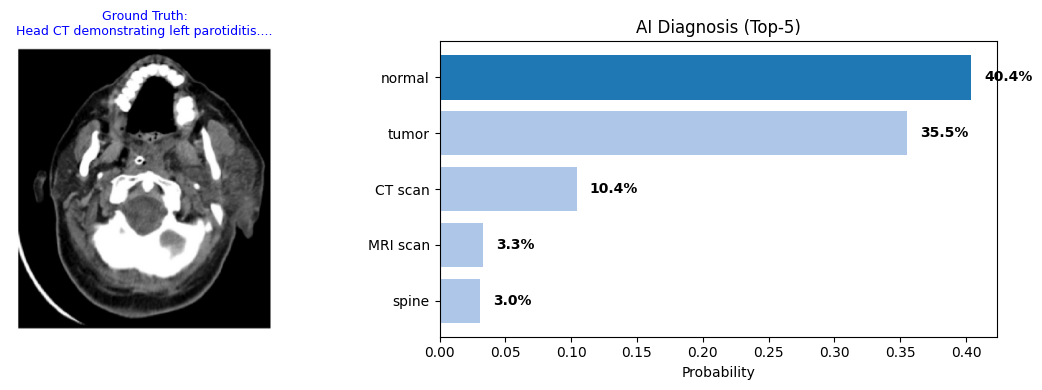

--- 测试样本 2/20 ---


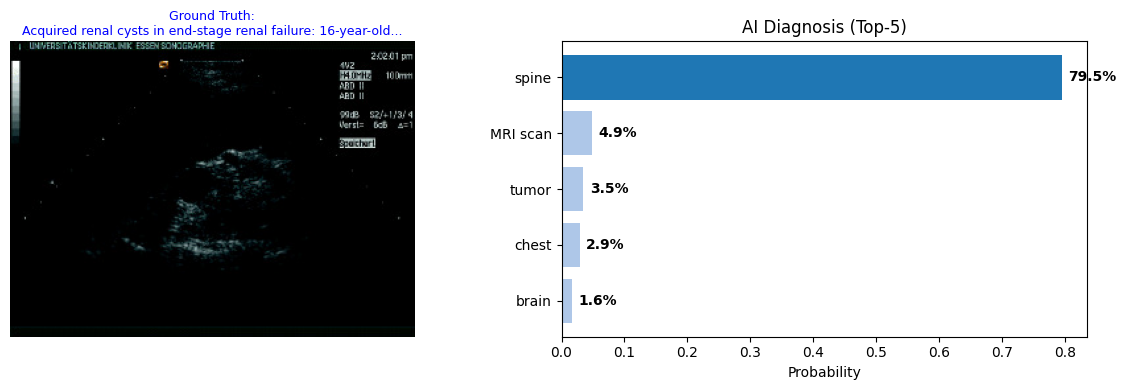

--- 测试样本 3/20 ---


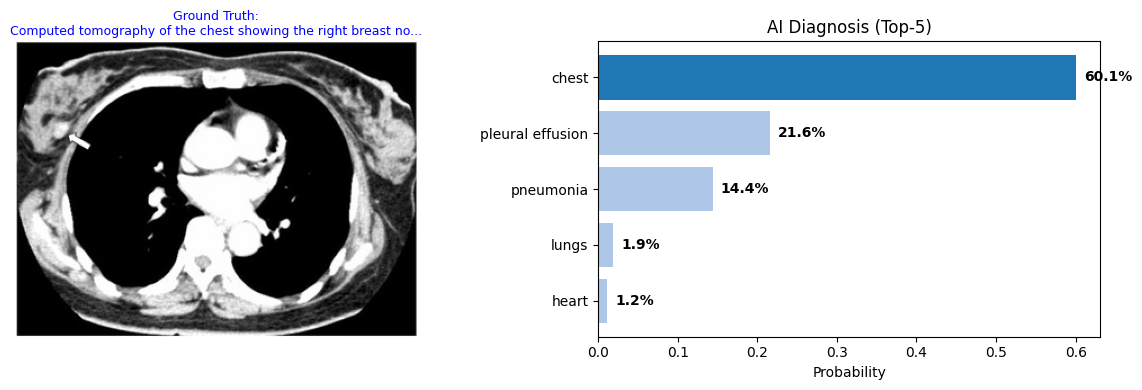

--- 测试样本 4/20 ---


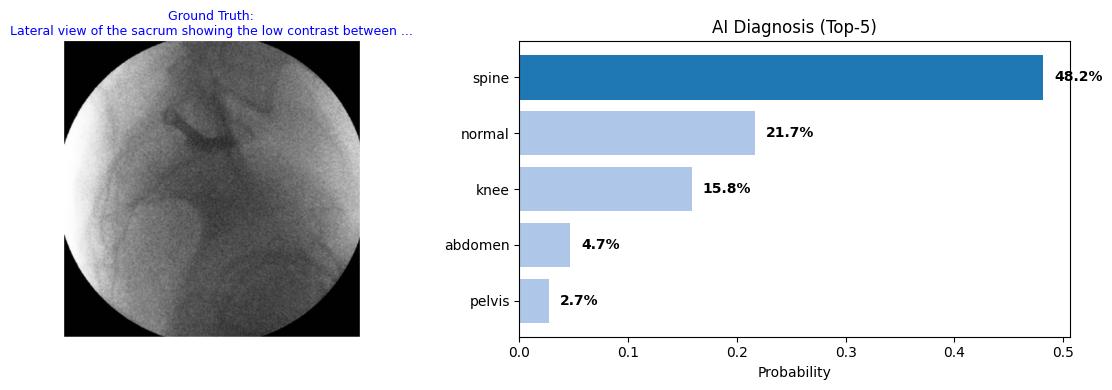

--- 测试样本 5/20 ---


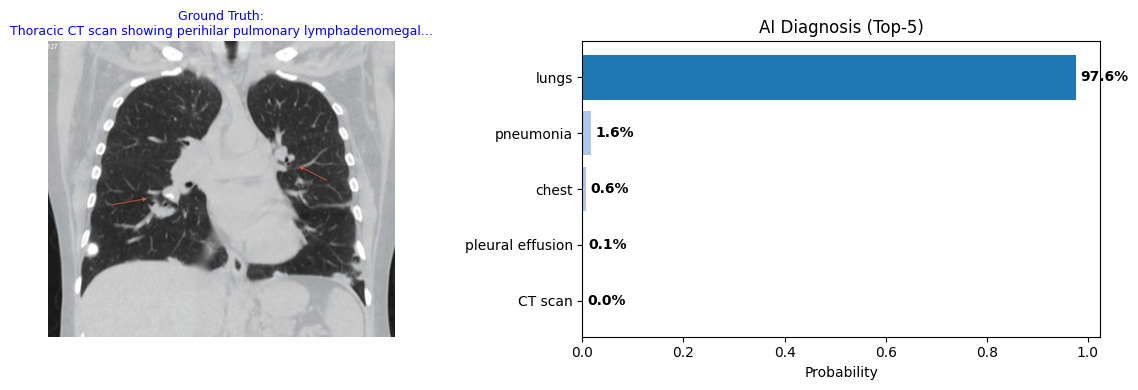

--- 测试样本 6/20 ---


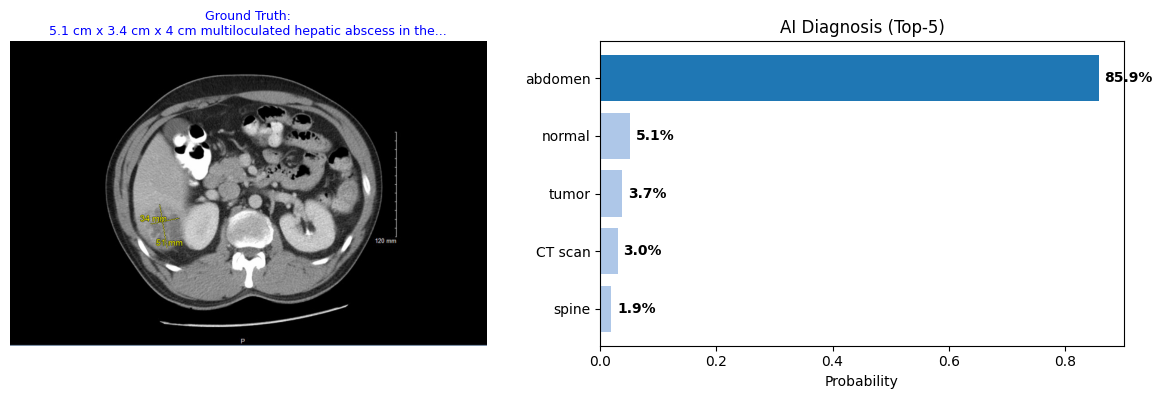

--- 测试样本 7/20 ---


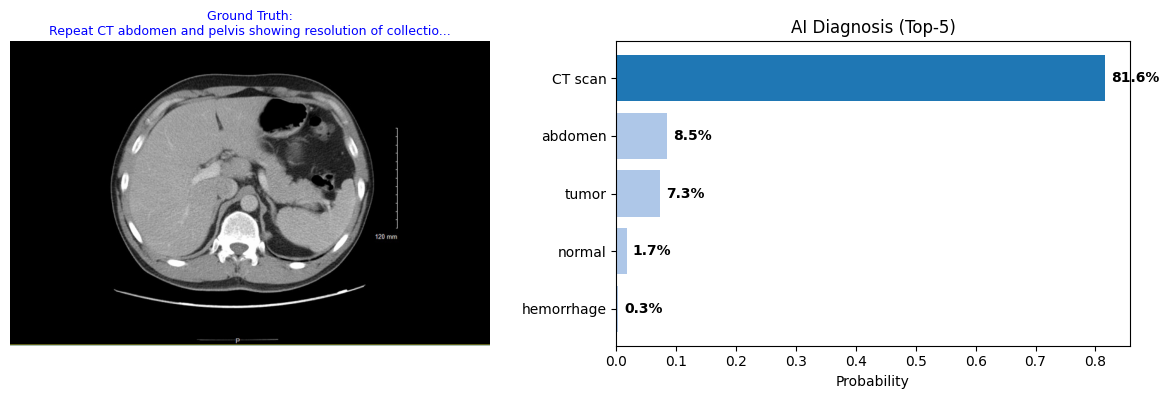

--- 测试样本 8/20 ---


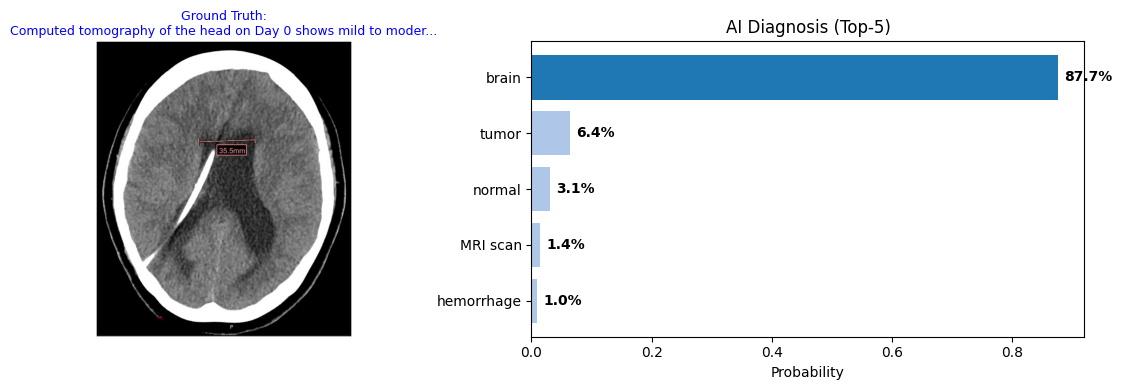

--- 测试样本 9/20 ---


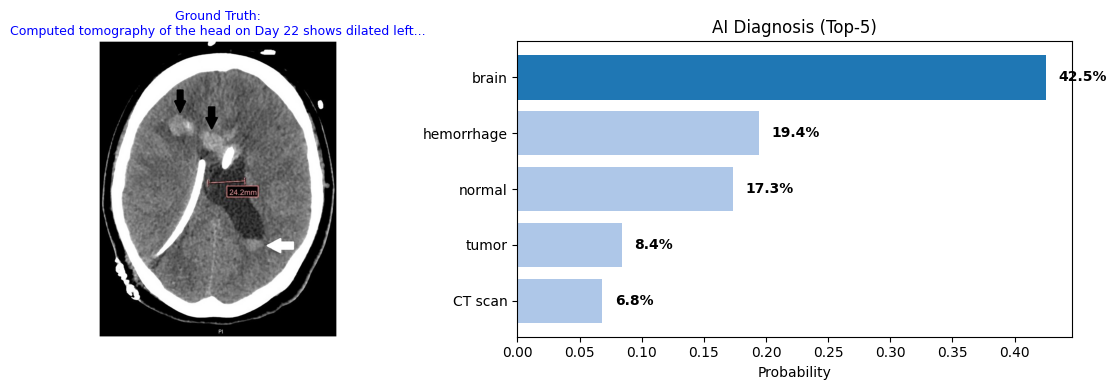

--- 测试样本 10/20 ---


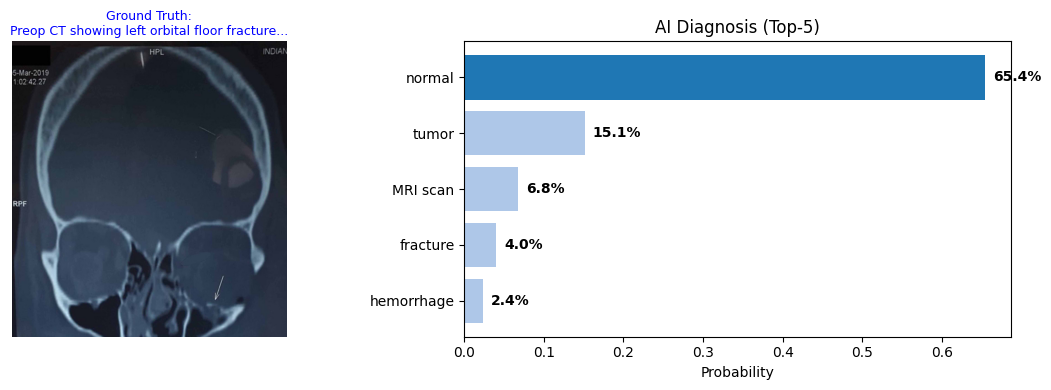

--- 测试样本 11/20 ---


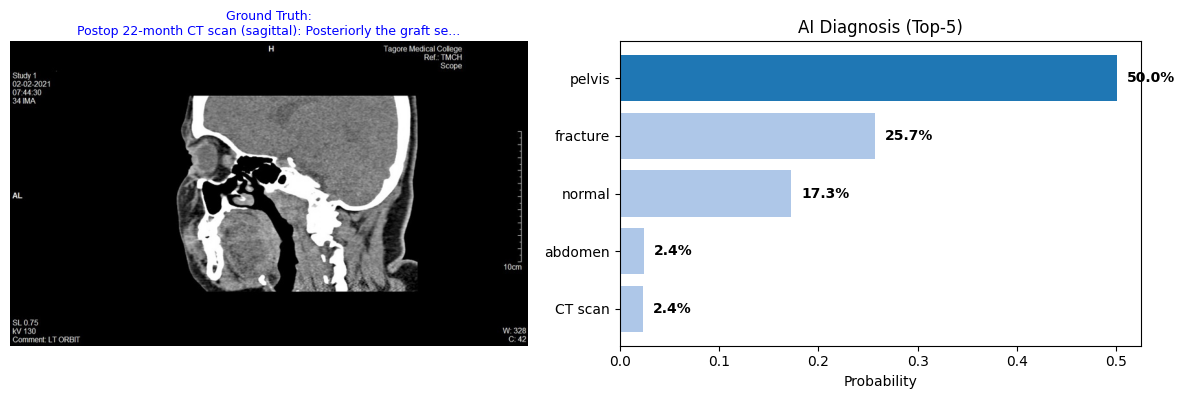

--- 测试样本 12/20 ---


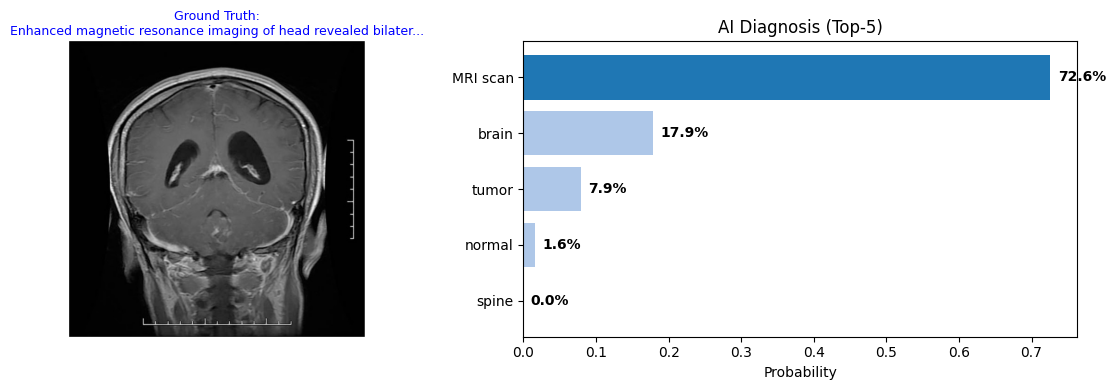

--- 测试样本 13/20 ---


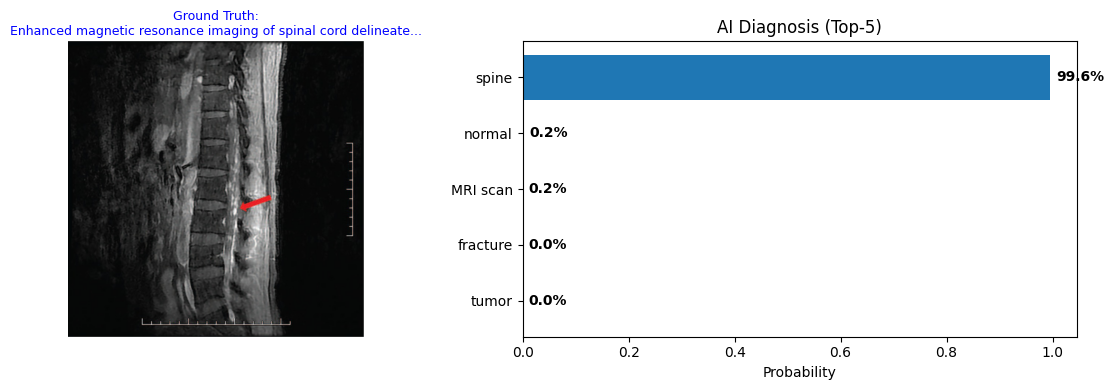

--- 测试样本 14/20 ---


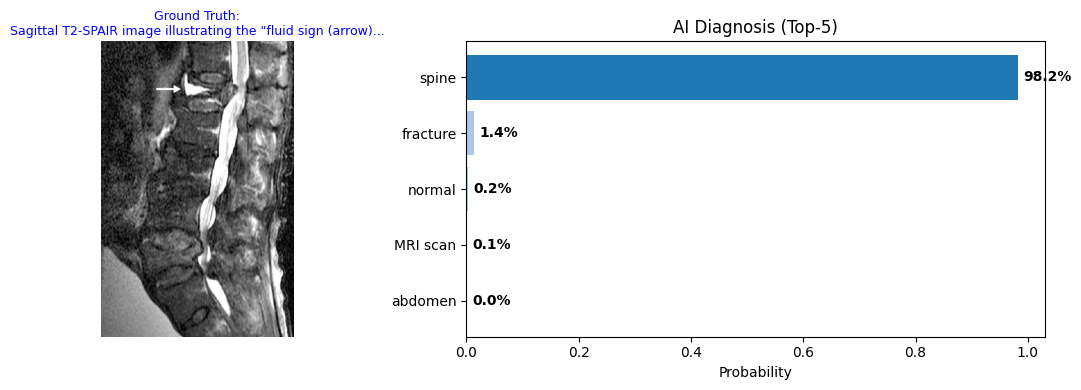

--- 测试样本 15/20 ---


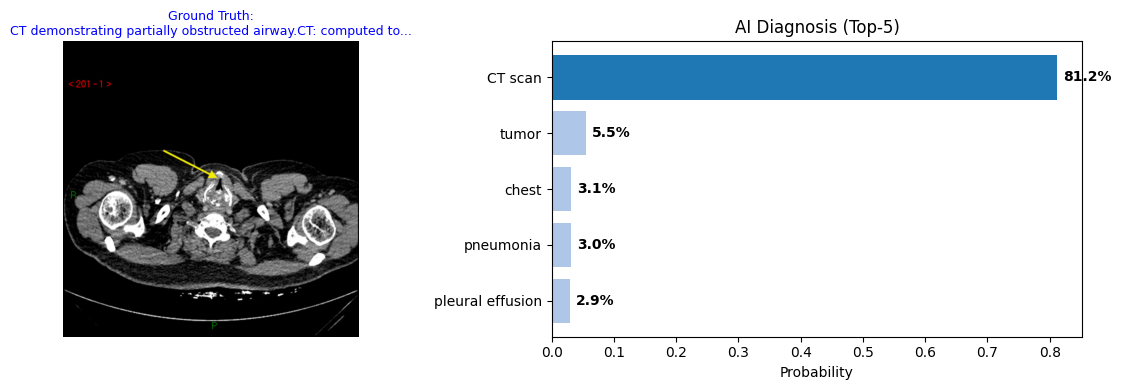

--- 测试样本 16/20 ---


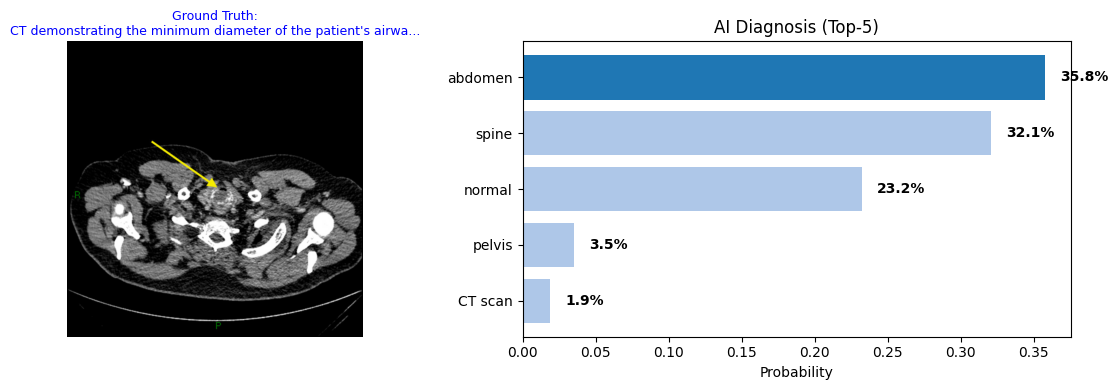

--- 测试样本 17/20 ---


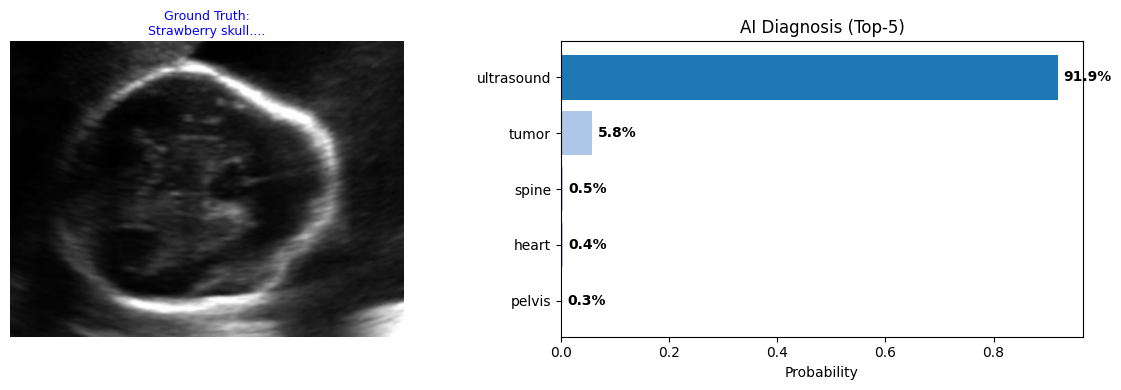

--- 测试样本 18/20 ---


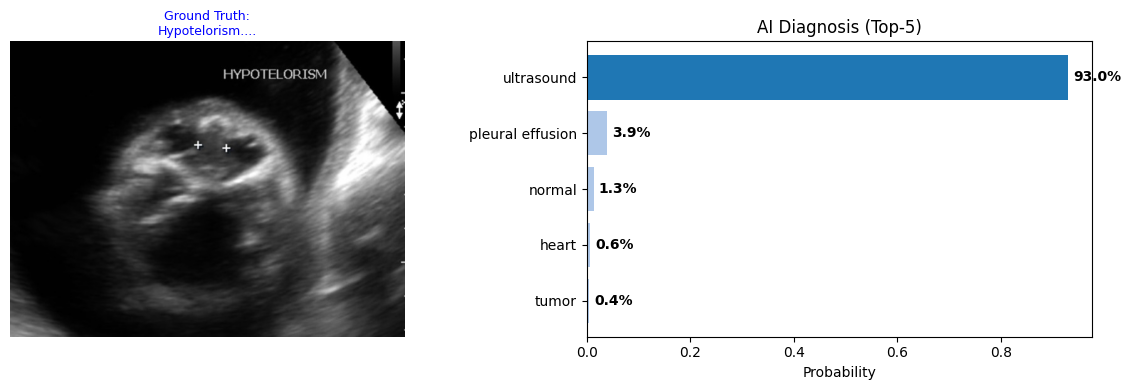

--- 测试样本 19/20 ---


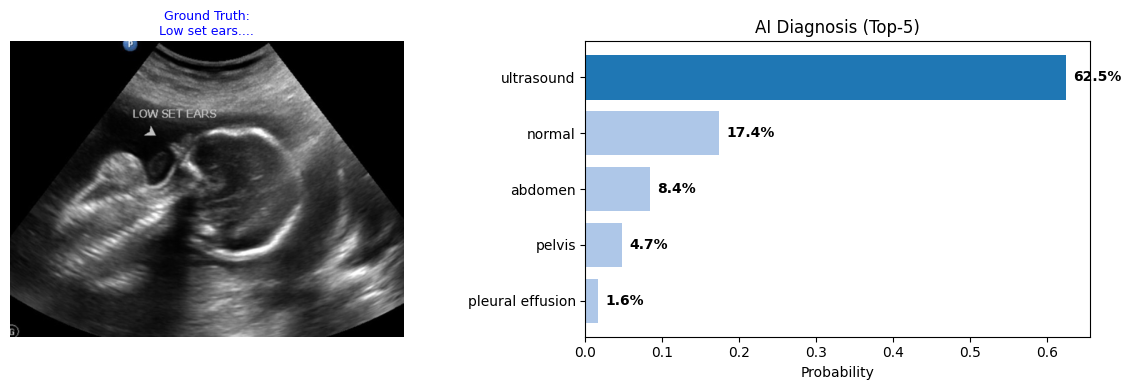

--- 测试样本 20/20 ---


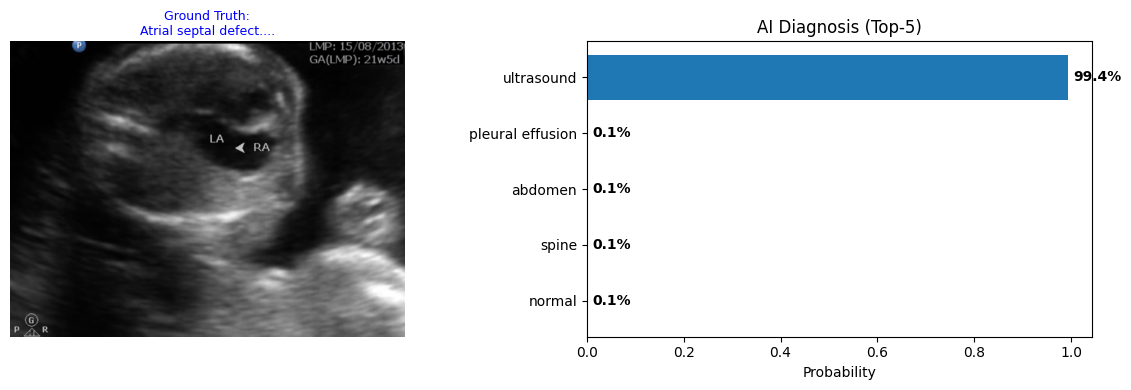

In [28]:
# show the results of 20 images
test_random_hard_samples(dataset, model, processor, num_samples=20)

6. text image retrival

🔍 正在图库(Batch=32)中搜索: 'spine' ...
✅ 找到最匹配的前 3 张图片索引: [8, 3, 29]


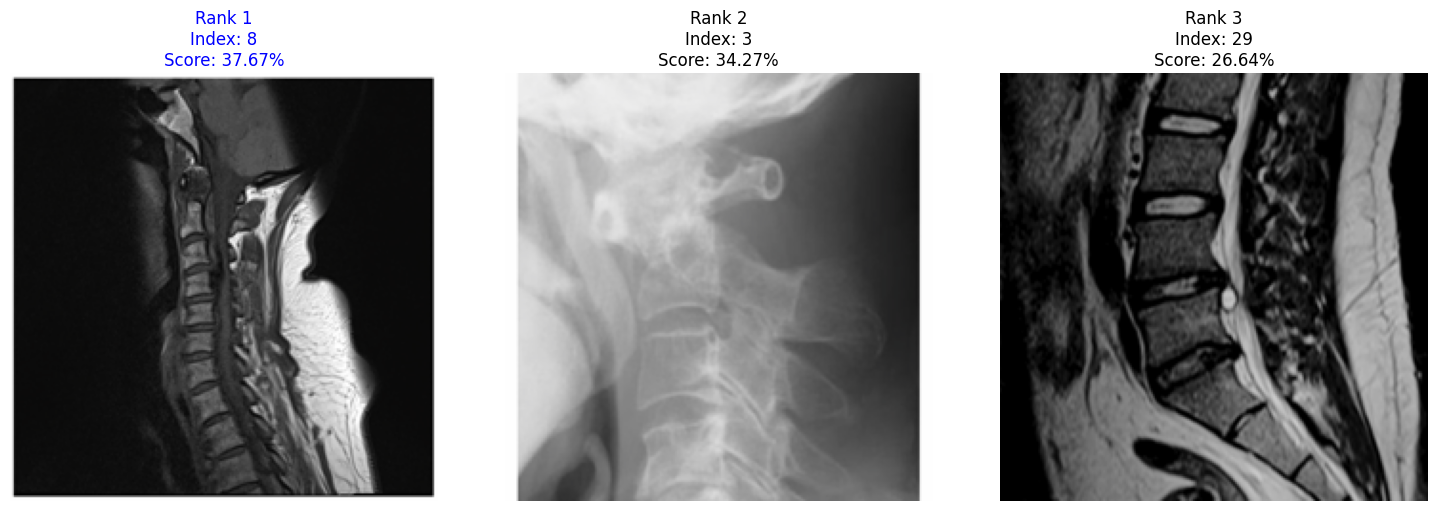

In [20]:
import matplotlib.pyplot as plt

demo_batch = next(iter(train_loader))
batch_images = demo_batch['pixel_values'].to(device)

# to define what we want to search
query_text = "spine"
print(f"searching: '{query_text}' ...")

# extracting the attributes
text_inputs = processor(text=[query_text], return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    # got the eigenvector
    text_features = model.get_text_features(**text_inputs)
    image_features = model.get_image_features(pixel_values=batch_images)


    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()
    logits = (text_features @ image_features.T) * logit_scale


    probs = logits.softmax(dim=-1)


top_k = 3
top_scores, top_indices = probs[0].topk(top_k)

print(f"Find the top{top_k}  most relevant image indexes: {top_indices.tolist()}")

plt.figure(figsize=(15, 5))

for i in range(top_k):

    idx = top_indices[i].item()
    score = top_scores[i].item()


    plt.subplot(1, top_k, i + 1)


    img_tensor = batch_images[idx].cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])
    img_display = std * img_tensor + mean
    img_display = np.clip(img_display, 0, 1)
    plt.imshow(img_display)

    plt.title(f"Rank {i+1}\nIndex: {idx}\nScore: {score:.2%}", color="blue" if i==0 else "black")
    plt.axis("off")

plt.tight_layout()
plt.show()

7. Evaluation

In [33]:
import torch
import numpy as np
from tqdm import tqdm

def evaluate_retrieval(dataloader, model, processor, device):
    print(" Calculating retrieval metrics (Recall@K)...")
    model.eval()


    all_image_embeds = []
    all_text_embeds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Encoding Features"):

            images = batch['pixel_values'].to(device)
            img_feat = model.get_image_features(pixel_values=images)
            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
            all_image_embeds.append(img_feat.cpu())


            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            txt_feat = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            txt_feat = txt_feat / txt_feat.norm(dim=-1, keepdim=True)
            all_text_embeds.append(txt_feat.cpu())


    image_feats = torch.cat(all_image_embeds, dim=0)
    text_feats = torch.cat(all_text_embeds, dim=0)

    n_samples = image_feats.shape[0]
    print(f"\nnumber of samples: {n_samples}")

    # 3. 计算相似度矩阵 [N, N]
    # sim_matrix[i, j] 表示第 i 张图 和 第 j 句话 的相似度
    sim_matrix = image_feats @ text_feats.T


    labels = torch.arange(n_samples)


    top10_preds = sim_matrix.argsort(dim=1, descending=True)[:, :10]


    matches = (top10_preds == labels.view(-1, 1))

    r1 = matches[:, :1].sum().item() / n_samples
    r5 = matches[:, :5].sum().item() / n_samples
    r10 = matches[:, :10].sum().item() / n_samples

    print("-" * 30)
    print(f"🏆 R@1  (Top-1 Accuracy):  {r1:.2%}")
    print(f"🥈 R@5  (Top-5 Accuracy):  {r5:.2%}")
    print(f"🥉 R@10 (Top-10 Accuracy): {r10:.2%}")
    print("-" * 30)

    return r1, r5, r10

eval_dataset = load_dataset("eltorio/ROCOv2-radiology", split="train", streaming=True).take(500)
eval_loader = DataLoader(list(eval_dataset), batch_size=32, collate_fn=collate_fn)

evaluate_retrieval(eval_loader, model, processor, device)

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 33e49ce9-b88f-456d-9c6b-81a1610fdc19)')' thrown while requesting GET https://huggingface.co/datasets/eltorio/ROCOv2-radiology/resolve/80ffeef4eb8d34d27cb5c2815305f1d8aee8a83c/data/train-00000-of-00027.parquet
Retrying in 1s [Retry 1/5].


 正在计算检索指标 (Recall@K)...


Encoding Features: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]



🔍 评估样本数: 500
------------------------------
🏆 R@1  (Top-1 Accuracy):  6.00%
🥈 R@5  (Top-5 Accuracy):  20.20%
🥉 R@10 (Top-10 Accuracy): 29.40%
------------------------------


(0.06, 0.202, 0.294)